# Lets tweak the code

In [174]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

df = df.iloc[:, 4:]

daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 23.1MB/s]


2020-01-22    555
2020-01-23     98
2020-01-24    288
2020-01-25    493
2020-01-26    684
dtype: int64

In [175]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(daily_cases.values.reshape(-1, 1))
data_tensor = torch.FloatTensor(scaled_data)

In [176]:
print(data_tensor.shape)

torch.Size([41, 1])


In [177]:
split_ratio = 0.8
split_idx = int(len(daily_cases) * split_ratio)
train_data = daily_cases[:split_idx]
test_data = daily_cases[split_idx:]

In [178]:
print(train_data.shape)

(32,)


In [179]:
scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Hyperparameters
seq_length = 7
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 1000

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

In [163]:
print(X_train[0])
print(y_train[0])
print(X_train[1])
print(y_train[1])
print(X_train[2])
print(y_train[2])

[[0.03036545]
 [0.        ]
 [0.01262458]
 [0.02624585]
 [0.03893688]]
[0.04724252]
[[0.        ]
 [0.01262458]
 [0.02624585]
 [0.03893688]
 [0.04724252]]
[0.16963455]
[[0.01262458]
 [0.02624585]
 [0.03893688]
 [0.04724252]
 [0.16963455]]
[0.03255814]


In [180]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)



In [181]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [182]:
num_epochs=10

# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model back to training mode
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.float())
    loss.backward()
    optimizer.step()

     # RMSE calculation for X_test and y_test
    model.eval()
    with torch.no_grad():
        test_inputs = X_test.float()
        predicted = model(test_inputs)
        predicted_actual = scaler.inverse_transform(predicted)
        ggg=scaler.inverse_transform(y_test.numpy())
        print(f'The predicted value: {predicted_actual} \n the y_test: {ggg}')
        rmse = np.sqrt(((predicted_actual - ggg) ** 2).mean())



    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, RMSE: {rmse:.4f}')

    # if (epoch + 1) % 1 == 0:
    #     print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
# model.eval()
# with torch.no_grad():
#     test_inputs = X_test.float()
#     predicted = model(test_inputs)
#     predicted = scaler.inverse_transform(predicted)

# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.title("COVID-19 Daily Cases Forecast")
# plt.xlabel("Day")
# plt.ylabel("Daily Cases")
# plt.plot(daily_cases.index[-len(test_data):], test_data, label="Actual", color="blue")
# plt.plot(daily_cases.index[-len(test_data):], predicted, label="Predicted", color="red")
# plt.legend()
# plt.show()


RuntimeError: ignored

In [157]:
# Make predictions
model.eval()
with torch.no_grad():
    predicted_value = model(X_test[0]).item()  # Use .item() to convert to a scalar value

RuntimeError: ignored

# The code below work like a charm

In [183]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

df = df.iloc[:, 4:]

daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)


# Hyperparameters
seq_length = 5
input_size = 1
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 100

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out




# Initialize the model
model = LSTM(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    outputs = model(X_train.float())
    optimizer.zero_grad()
    loss = criterion(outputs, y_train.float())
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    test_inputs = X_test.float()
    predicted = model(test_inputs)
    predicted = scaler.inverse_transform(predicted)

# # Plot the results
# plt.figure(figsize=(12, 6))
# plt.title("COVID-19 Daily Cases Forecast")
# plt.xlabel("Day")
# plt.ylabel("Daily Cases")
# plt.plot(daily_cases.index[-len(test_data):], test_data, label="Actual", color="blue")
# plt.plot(daily_cases.index[-len(test_data):], predicted, label="Predicted", color="red")
# plt.legend()
# plt.show()


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 25.8MB/s]


RuntimeError: ignored

In [82]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

df = df.iloc[:, 4:]

daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()

test_data_size = 14

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]

train_data.shape

scaler = MinMaxScaler()

scaler = scaler.fit(np.expand_dims(train_data, axis=1))

train_data = scaler.transform(np.expand_dims(train_data, axis=1))

test_data = scaler.transform(np.expand_dims(test_data, axis=1))

def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

class CoronaVirusPredictor(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()

        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = \
            lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

loss_fn = torch.nn.MSELoss(reduction='sum')
model = CoronaVirusPredictor(
    n_features=1,
    n_hidden=512,
    seq_len=seq_length,
    n_layers=2
)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 60

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)

for t in range(num_epochs):
    model.reset_hidden_state()

    y_pred = model(X_train)

    loss = loss_fn(y_pred.float(), y_train)

    if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()
# ```

# This code combines the training logic into the main code without using a separate `train_model` function. It also prints the training loss for every 10 epochs for better tracking.

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 24.4MB/s]
Epoch 0 train loss: 1.6297187805175781
Epoch 10 train loss: 0.8438199758529663
Epoch 20 train loss: 0.8421940803527832
Epoch 30 train loss: 0.7994419932365417
Epoch 40 train loss: 0.8171691298484802
Epoch 50 train loss: 0.806649386882782


In [76]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from torch import nn, optim
from pandas.plotting import register_matplotlib_converters
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set visualization parameters
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
plt.rcParams['figure.figsize'] = (14, 10)
register_matplotlib_converters()

# Download data
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 42.6MB/s]


In [77]:
# Load and preprocess data
df = pd.read_csv('time_series_19-covid-Confirmed.csv').iloc[:, 4:]
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)


daily_cases = daily_cases.diff().fillna(daily_cases[0]).astype(np.int64)
daily_cases.head()
uni_data_df = daily_cases.copy()


In [78]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(uni_data_df.values.reshape(-1, 1))
data_tensor = torch.FloatTensor(scaled_data)

# Define function to create sequences from time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length:i + seq_length + 1]
        sequences.append((x, y))
    return sequences

# Set sequence length
seq_length = 5
sequences = create_sequences(data_tensor, seq_length)

# Split data into training and testing sets
split_ratio = 0.8
split_idx = int(len(sequences) * split_ratio)
train_sequences = sequences[:split_idx]
test_sequences = sequences[split_idx:]

# Create DataLoader for training and testing
batch_size = 64
train_loader = DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_sequences, batch_size=batch_size, shuffle=False)

# Define LSTM Model
class CoronaVirusPredictor(nn.Module):
    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(CoronaVirusPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            dropout=0.5
        )
        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
            sequences.view(len(sequences), self.seq_len, -1),
            self.hidden
        )
        last_time_step = lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)
        return y_pred

# Create the model
model = CoronaVirusPredictor(n_features=1, n_hidden=512, seq_len=seq_length, n_layers=2)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 60
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.float(), batch_y.float()
        model.reset_hidden_state()
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_x)

        # Reshape the target tensor to match the output shape
        batch_y = batch_y.squeeze(dim=1)

        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_loss = 0
    predictions = []

    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.float(), batch_y.float()
            model.reset_hidden_state()
            outputs = model(batch_x)

            # Reshape the target tensor to match the output shape
            batch_y = batch_y.squeeze(dim=1)

            test_loss += criterion(outputs, batch_y).item()
            predictions.append(outputs.numpy())

    test_loss /= len(test_loader)

    # Calculate RMSE
    predictions = np.concatenate(predictions)
    predictions = scaler.inverse_transform(predictions)
    y_true = scaler.inverse_transform(np.concatenate([y.numpy() for _, y in test_sequences]))
    rmse = np.sqrt(mean_squared_error(y_true, predictions))

    print(f"Epoch {epoch}: train RMSE {np.sqrt(train_loss):.4f}, test RMSE {rmse:.4f}")

Epoch 52: train RMSE 0.1863, test RMSE 1468.2245
Epoch 53: train RMSE 0.1841, test RMSE 1443.1698
Epoch 54: train RMSE 0.1844, test RMSE 1420.5577
Epoch 55: train RMSE 0.1840, test RMSE 1396.2078
Epoch 56: train RMSE 0.1850, test RMSE 1376.7039
Epoch 57: train RMSE 0.1838, test RMSE 1368.9845
Epoch 58: train RMSE 0.1832, test RMSE 1371.1018
Epoch 59: train RMSE 0.1842, test RMSE 1385.0974


# Time Series Forecasting with LSTMs for Daily Coronavirus Cases using PyTorch in Python

> This tutorial is NOT trying to build a model that predicts the Covid-19 outbreak/pandemic in the best way possible. This is an example of how you can use Recurrent Neural Networks on some real-world Time Series data with PyTorch. Hopefully, there are much better models that predict the number of daily confirmed cases.

Time series data captures a series of data points recorded at (usually) regular intervals. Some common examples include daily weather temperature, stock prices, and the number of sales a company makes.

Many classical methods (e.g. ARIMA) try to deal with Time Series data with varying success (not to say they are bad at it). In the last couple of years, [Long Short Term Memory Networks (LSTM)](https://en.wikipedia.org/wiki/Long_short-term_memory) models have become a very useful method when dealing with those types of data.

Recurrent Neural Networks (LSTMs are one type of those) are very good at processing sequences of data. They can "recall" patterns in the data that are very far into the past (or future). In this tutorial, you're going to learn how to use LSTMs to predict future Coronavirus cases based on real-world data.

- [Run the complete notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1nQYJq1f7f4R0yeZOzQ9rBKgk00AfLoS0)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

## Novel Coronavirus (COVID-19)

The novel Coronavirus (Covid-19) has spread around the world very rapidly. At the time of this writing, [Worldometers.info](https://www.worldometers.info/coronavirus/) shows that there are more than *95,488* confirmed cases in more than *84* countries.

The top 4 worst-affected (by far) are China (the source of the virus), South Korea, Italy, and Iran. Unfortunately, many cases are currently not reported due to:

- A person can get infected without even knowing (asymptomatic)
- Incorrect data reporting
- Not enough test kits
- The symptoms look a lot like the common flu

### How dangerous is this virus?

Except for the common statistics you might see cited on the news, there are some good and some bad news:

- More than 80% of the confirmed cases recover without any need of medical attention
- [3.4% Mortality Rate estimate by the World Health Organization (WHO) as of March 3](https://www.worldometers.info/coronavirus/coronavirus-death-rate/#who-03-03-20)
- The reproductive number which represents the average number of people to which a single infected person will transmit the virus is between 1.4 and 2.5 [(WHO's estimated on Jan. 23)](https://www.worldometers.info/coronavirus/#repro)

The last one is really scary. It sounds like we can witness some crazy exponential growth if appropriate measures are not put in place.

Let's get started!

In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [ ]:
# !wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv

In [2]:
!gdown --id 1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AsfdLrGESCQnRW5rbMz56A1KBc3Fe5aV
To: /content/time_series_19-covid-Confirmed.csv
100% 19.2k/19.2k [00:00<00:00, 35.5MB/s]


In [3]:
df = pd.read_csv('time_series_19-covid-Confirmed.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,989,989,989,989,989,989,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,399,399,399,400,400,410,410,411,413,414
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,573,575,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,293,293,293,294,294,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,91,91,91,91


Two things to note here:

- The data contains a province, country, latitude, and longitude. We won't be needing those.
- The number of cases is cumulative. We'll undo the accumulation.

Let's start by getting rid of the first four columns:

In [4]:
df = df.iloc[:, 4:]

In [5]:
df.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20
0,1,9,15,39,60,70,106,152,200,237,...,989,989,989,989,989,989,990,990,990,990
1,14,22,36,41,68,80,91,111,114,139,...,399,399,399,400,400,410,410,411,413,414
2,6,9,27,57,75,110,132,147,182,211,...,573,575,576,576,576,576,576,576,576,576
3,1,5,10,18,35,59,80,84,101,120,...,293,293,293,294,294,296,296,296,296,296
4,0,2,2,4,7,14,19,24,26,29,...,91,91,91,91,91,91,91,91,91,91


In [6]:
df.isnull().sum().sum()

0

In [7]:
daily_cases = df.sum(axis=0)
daily_cases.index = pd.to_datetime(daily_cases.index)
daily_cases.head()

2020-01-22     555
2020-01-23     653
2020-01-24     941
2020-01-25    1434
2020-01-26    2118
dtype: int64

In [22]:
uni_data_df = daily_cases.copy()
X = uni_data_df.values
# print(uni_data_df)
X_reshaped = X.reshape(-1, 1)

In [23]:
# Normalize the data using Min-Max scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(X_reshaped)

# Convert the scaled data to PyTorch tensors
data_tensor = torch.FloatTensor(scaled_data)

In [24]:
# Define a function to create sequences from the time series data
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+1]
        sequences.append((x, y))
    return sequences

In [25]:
# Set the sequence length
seq_length = 5

# Create sequences
sequences = create_sequences(data_tensor, seq_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_idx = int(len(sequences) * split_ratio)
train_sequences = sequences[:split_idx]
test_sequences = sequences[split_idx:]

In [26]:
# Create DataLoader for training and testing
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_sequences, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_sequences, batch_size=batch_size, shuffle=False)

In [83]:
# Define LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Create the model
input_size = 1  # Univariate data
hidden_size = 64
num_layers = 2
output_size = 1

model = LSTM(input_size, hidden_size, num_layers, output_size)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2

In [71]:
import torch
import torch.nn as nn

# Define LSTM Model
class CoronaVirusPredictor(nn.Module):

  def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
    super(CoronaVirusPredictor, self).__init__()

    self.n_hidden = n_hidden
    self.seq_len = seq_len
    self.n_layers = n_layers

    self.lstm = nn.LSTM(
      input_size=n_features,
      hidden_size=n_hidden,
      num_layers=n_layers,
      dropout=0.5
    )

    self.linear = nn.Linear(in_features=n_hidden, out_features=1)

  def reset_hidden_state(self):
    self.hidden = (
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
        torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
    )

  def forward(self, sequences):
    lstm_out, self.hidden = self.lstm(
      sequences.view(len(sequences), self.seq_len, -1),
      self.hidden
    )
    last_time_step = \
      lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
    y_pred = self.linear(last_time_step)
    return y_pred

# Create the model
input_size = 1  # Univariate data
hidden_size = 64
num_layers = 2
output_size = 1

model = CoronaVirusPredictor(
  n_features=1,
  n_hidden=512,
  seq_len=seq_length,
  n_layers=2
)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 2
# Rest of your training code...


In [31]:
# import tensorflow as tf
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd


In [ ]:
loss_fn = torch.nn.MSELoss(reduction='sum')

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 2

train_hist = np.zeros(num_epochs)
test_hist = np.zeros(num_epochs)

for t in range(num_epochs):
  model.reset_hidden_state()

  y_pred = model(X_train)

  loss = loss_fn(y_pred.float(), y_train)

    if test_data is not None:
      with torch.no_grad():
        y_test_pred = model(X_test)
        test_loss = loss_fn(y_test_pred.float(), y_test)
      test_hist[t] = test_loss.item()

      if t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')
    elif t % 10 == 0:
      print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()

    optimiser.zero_grad()

    loss.backward()

    optimiser.step()

In [72]:
# Inside the training loop





for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_x, batch_y in train_loader:

        batch_x, batch_y = batch_x.float(), batch_y.float()

        # Forward pass
        outputs = model(batch_x)

        # Reshape the target tensor to match the output shape
        batch_y = batch_y.squeeze(dim=1)

        loss = criterion(outputs, batch_y)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Evaluation on the test set
    model.eval()
    test_loss = 0
    predictions = []
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.float(), batch_y.float()
        with torch.no_grad():
            outputs = model(batch_x)

            # Reshape the target tensor to match the output shape
            batch_y = batch_y.squeeze(dim=1)

            test_loss += criterion(outputs, batch_y).item()
            predictions.append(outputs.numpy())

    test_loss /= len(test_loader)

    # Calculate RMSE
    predictions = np.concatenate(predictions)
    predictions = scaler.inverse_transform(predictions)
    y_true = scaler.inverse_transform(np.concatenate([y.numpy() for _, y in test_sequences]))
    rmse = np.sqrt(mean_squared_error(y_true, predictions))

    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, np.sqrt(train_loss), rmse))


AttributeError: ignored

In [33]:
print(y_true[0])

[79570.]


In [34]:
print(predictions[0])

[-40.23896]


In [35]:
# Convert the data to PyTorch tensors
# Assuming you have already defined 'test_sequences'
data_tensor = torch.FloatTensor(test_sequences[0][0]).view(1, -1, 1)  # Use the first sequence in the test data

In [36]:
# Make predictions
model.eval()
with torch.no_grad():
    predicted_value = model(data_tensor).item()  # Use .item() to convert to a scalar value

In [38]:
print(test_sequences[0][0])

tensor([[0.8365],
        [0.8428],
        [0.8499],
        [0.8695],
        [0.8738]])


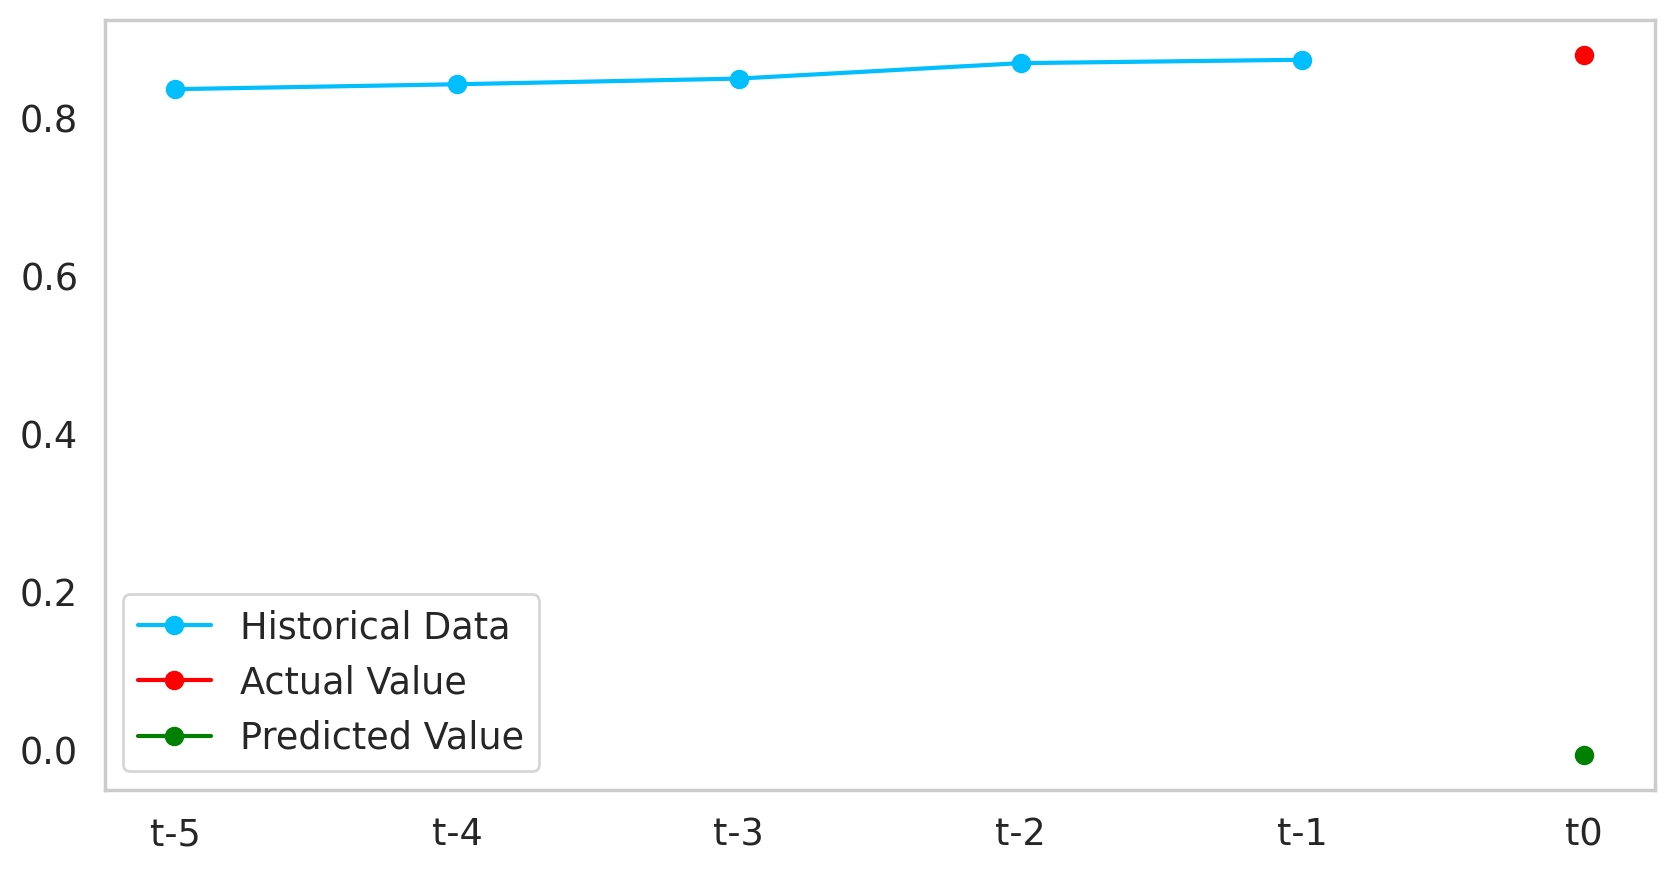

Actual Value: tensor([0.8803])
Predicted Value: -0.006631597876548767


In [51]:
# Plot the historical data, actual value, and predicted value
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, seq_length+1), test_sequences[0][0], marker='o', label='Historical Data')
plt.plot((seq_length+1), test_sequences[0][1][0], marker='o', label='Actual Value', color='red')
plt.plot((seq_length+1), predicted_value, marker='o', label='Predicted Value', color='green')
labelsx=['t-5', 't-4', 't-3', 't-2', 't-1', 't0']
plt.xticks(np.arange(1, seq_length+2), labels=labelsx)
plt.legend()
plt.grid()
plt.show()


# Print the actual and predicted values
print("Actual Value:", test_sequences[0][1][0])
print("Predicted Value:", predicted_value)